# Tabular Playground Series - Jul 2022 by Kaggle

### Dataset Description

For this challenge, you are given (simulated) manufacturing control data that can be clustered into different control states. Your task is to cluster the data into these control states. You are not given any training data, and you are not told how many possible control states there are. This is a completely unsupervised problem, one you might encounter in a real-world setting.

Good luck!

Files
data.csv - the file includes continuous and categorical data; your task is to predict which rows should be clustered together in a control state
sample_submission.csv - a sample submission file in the correct format, where Predicted is the predicted control state

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.mixture import GaussianMixture

In [2]:
df_wh = pd.read_csv('wrangled_wh_data.csv')

### Exploratory Data Analysis and wrangling were performed earlier, you can find full description in previous file tpsWrangling_EDA.ipynb.
Please check [GitHub](https://github.com/raz0r-b1ade/TPSProject/blob/main/tpsWrangling_EDA.ipynb)

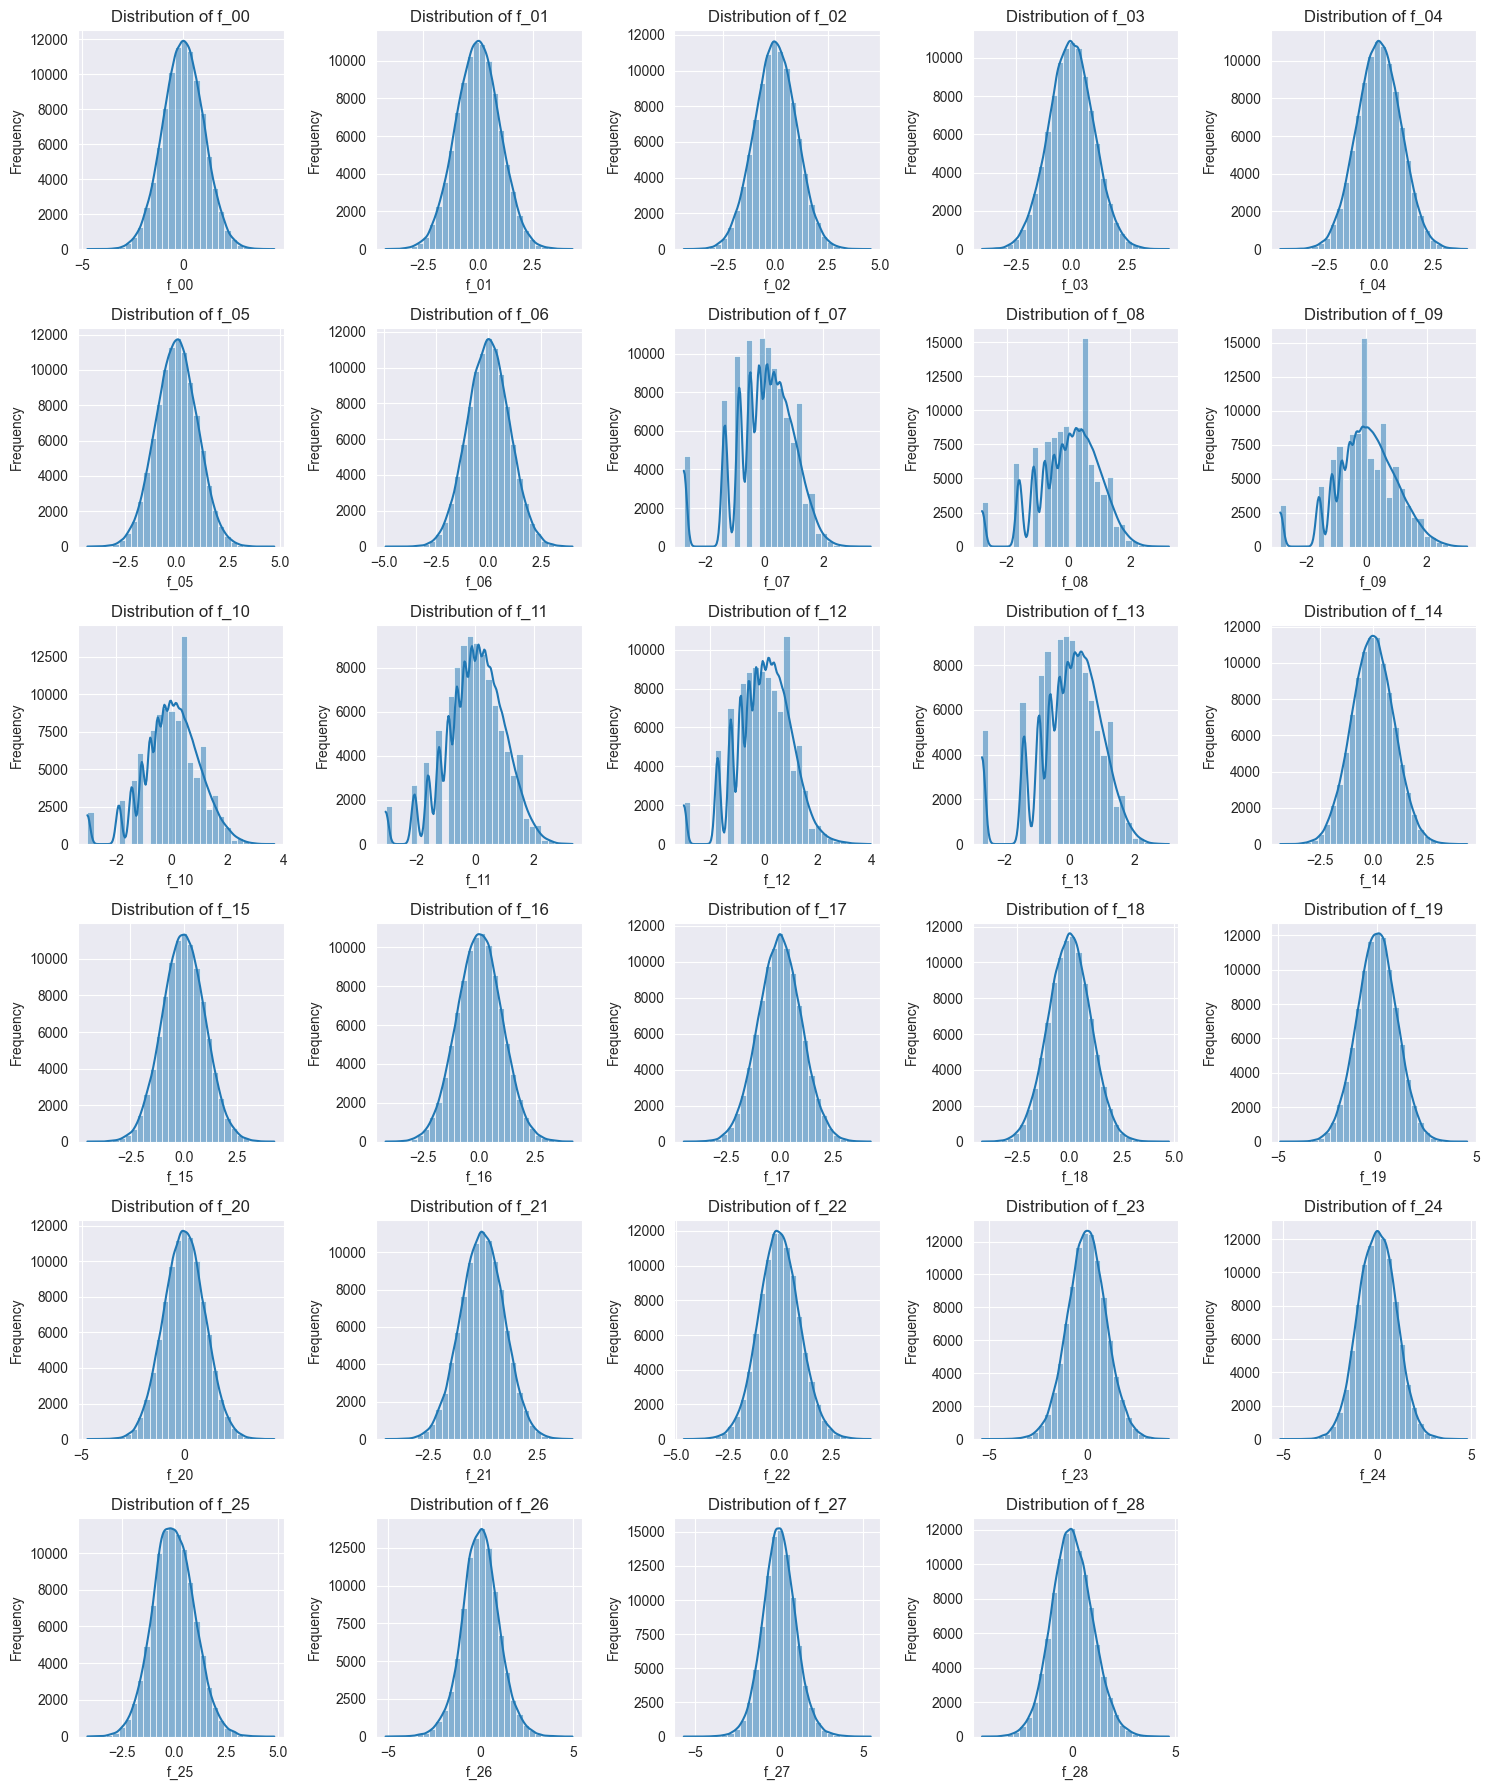

In [3]:
# All feature columns (excluding the 'id' column)
feature_columns = df_wh.columns[1:]

# Number of rows and columns for subplots
n_rows = len(feature_columns) // 5 + (1 if len(feature_columns) % 5 != 0 else 0)

plt.figure(figsize=(15, 3 * n_rows))
for i, col in enumerate(feature_columns, 1):
    plt.subplot(n_rows, 5, i)
    sns.histplot(df_wh[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Initial Model:
Architecture:
Encoder:
Input layer with a dimension corresponding to the data features.
A hidden layer with 50 neurons and a ReLU activation function.
A compressed representation layer with 10 neurons (the encoding) and a ReLU activation function.
Decoder:
A layer mirroring the encoder's hidden layer (50 neurons, ReLU activation).
An output layer with a linear activation, aiming to reconstruct the original input data.
Training:
Optimizer: Adam with default learning rate.
Loss: Mean squared error.
Epochs: 50.
Batch Size: 256.
Validation Split: 20% of the data.
Data Shuffling: Yes.

In [4]:
# Define the autoencoder architecture
input_dim = df_wh.drop(columns=['id']).shape[1]
encoding_dim = 10

# Encoder architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(50, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# Decoder architecture
decoded = Dense(50, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [5]:
# Train the autoencoder
autoencoder.fit(df_wh.drop(columns=['id']), df_wh.drop(columns=['id']), epochs=50, batch_size=256, validation_split=0.2, shuffle=True)

# Extract the encoder
encoder = Model(input_layer, encoded)

# Use the encoder to get the compressed representation
compressed_data = encoder.predict(df_wh.drop(columns=['id']))

Epoch 1/50
307/307 [==============================] - 1s 2ms/step - loss: 0.7515 - val_loss: 0.6312
Epoch 2/50
307/307 [==============================] - 0s 1ms/step - loss: 0.6107 - val_loss: 0.5956
Epoch 3/50
307/307 [==============================] - 0s 1ms/step - loss: 0.5903 - val_loss: 0.5835
Epoch 4/50
307/307 [==============================] - 0s 1ms/step - loss: 0.5803 - val_loss: 0.5766
Epoch 5/50
307/307 [==============================] - 0s 1ms/step - loss: 0.5733 - val_loss: 0.5706
Epoch 6/50
307/307 [==============================] - 0s 1ms/step - loss: 0.5683 - val_loss: 0.5660
Epoch 7/50
307/307 [==============================] - 0s 1ms/step - loss: 0.5644 - val_loss: 0.5627
Epoch 8/50
307/307 [==============================] - 0s 1ms/step - loss: 0.5614 - val_loss: 0.5604
Epoch 9/50
307/307 [==============================] - 0s 1ms/step - loss: 0.5586 - val_loss: 0.5577
Epoch 10/50
307/307 [==============================] - 0s 1ms/step - loss: 0.5564 - val_loss: 0.5555

Modified Model:
Architecture:
Encoder:
Similar input layer.
A denser hidden layer with 128 neurons and ReLU activation.
A compressed representation layer with 25 neurons and ReLU activation.
Decoder:
A layer with 128 neurons and ReLU activation.
The output layer remains similar, aiming to reconstruct the input.
Training:
Optimizer: Adam, but with a reduced learning rate of 0.0001.
Loss: Mean squared error.
Epochs: Increased to 500, but early stopping is introduced, which will halt training if the validation loss doesn't improve significantly.
Batch Size: 256.
Validation Split: 20% of the data.
Data Shuffling: Yes.
Callbacks:
ReduceLROnPlateau which dynamically reduces the learning rate if the validation loss plateaus.
EarlyStopping which stops training if the validation loss doesn't improve for a certain number of epochs (patience).

In [62]:
# Encoder architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(25, activation='relu')(encoded)

# Decoder architecture
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)

# Reduced learning rate for Adam optimizer
adam = Adam(learning_rate=0.0001)

# Compile the autoencoder with the modified optimizer
autoencoder.compile(optimizer=adam, loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

In [63]:
# Train the autoencoder
autoencoder.fit(df_wh.drop(columns=['id']), df_wh.drop(columns=['id']),
                epochs=500,  # Increase max epochs as early stopping will halt when needed
                batch_size=256,
                validation_split=0.2,
                shuffle=True,
                callbacks=[reduce_lr, early_stopping]
                )

# Extract the encoder
encoder = Model(input_layer, encoded)

# Use the encoder to get the compressed representation
compressed_data = encoder.predict(df_wh.drop(columns=['id']))

Epoch 1/500
307/307 [==============================] - 1s 2ms/step - loss: 0.8982 - val_loss: 0.6975 - lr: 1.0000e-04
Epoch 2/500
307/307 [==============================] - 1s 2ms/step - loss: 0.5030 - val_loss: 0.3577 - lr: 1.0000e-04
Epoch 3/500
307/307 [==============================] - 1s 2ms/step - loss: 0.2762 - val_loss: 0.2229 - lr: 1.0000e-04
Epoch 4/500
307/307 [==============================] - 1s 2ms/step - loss: 0.2055 - val_loss: 0.1924 - lr: 1.0000e-04
Epoch 5/500
307/307 [==============================] - 1s 2ms/step - loss: 0.1839 - val_loss: 0.1755 - lr: 1.0000e-04
Epoch 6/500
307/307 [==============================] - 1s 2ms/step - loss: 0.1695 - val_loss: 0.1630 - lr: 1.0000e-04
Epoch 7/500
307/307 [==============================] - 1s 2ms/step - loss: 0.1583 - val_loss: 0.1528 - lr: 1.0000e-04
Epoch 8/500
307/307 [==============================] - 1s 2ms/step - loss: 0.1488 - val_loss: 0.1436 - lr: 1.0000e-04
Epoch 9/500
307/307 [==============================] - 1

Comparative Analysis:

The First Model started with higher loss values and showed a relatively rapid reduction in loss over the epochs. This suggests that the initial model had a more significant "distance" to cover in terms of learning.
The Modified Model, on the other hand, exhibited much lower loss values from the logs shared, and the rate of reduction in loss was slower. This could mean the model was already closer to its optimal performance when the logs started (from epoch 200), and the further training was more about fine-tuning.
The loss values of the modified model are significantly lower than the first model, suggesting it has a better performance in reconstructing the input data.
Conclusion:
The modified model, from the logs shared, seems to be the better-performing model given its lower loss values. The slow learning rate and marginal changes in loss suggest it was more about refining the model's performance rather than significant learning shifts.

In [66]:
# Apply GMM on the compressed data
gmm = GaussianMixture(n_components=10)  # Decide the value for number_of_clusters
predicted_labels = gmm.fit_predict(compressed_data)

In [67]:
submission = pd.DataFrame({
    'id': df_wh['id'],
    'predicted': predicted_labels
})

submission.to_csv('DL_submission.csv', index=False)

DL_submission.csv
Complete (after deadline) · now
0.26965

0.26672

DL_submission.csv
Complete (after deadline) · 2m ago
0.27345

0.27052

DL_submission.csv
Complete (after deadline) · 37m ago
0.03313

0.03135

DL_submission.csv
Complete (after deadline) · 37m ago
0.05015

0.04947

DL_submission.csv
Complete (after deadline) · 38m ago
0.07075

0.06899

DL_submission.csv
Complete (after deadline) · 2h ago
0.11553

0.11249



# Conclusion on Deep Learning GMM Approach
Approach Overview:
In this study, a hybrid method combining deep learning (using autoencoders) and Gaussian Mixture Models (GMM) was employed for clustering. The autoencoder served to reduce the dimensionality of the data, capturing its essential features in a compressed form. This compressed representation was then utilized as input for the GMM to segment the data into clusters.

Results:
From the scores presented:

There's a visible improvement in scores over iterations. This might be attributed to the fine-tuning of the model parameters and changing the number of clusters in the GMM.
The lowest scores (e.g., 0.03313 and 0.03135) indicate better performance in some configurations, suggesting that certain parameter combinations yielded particularly meaningful clusters.
Comparing the latest scores (e.g., 0.26965 and 0.26672) with earlier ones indicates a consistent performance, reinforcing the stability of the chosen model configuration.
Key Insights:

Deep Learning Advantage: The use of autoencoders for dimensionality reduction proved beneficial. By learning a compressed representation of the data, the autoencoder likely retained essential clustering information while removing potential noise or redundant features.
Tuning is Crucial: The iterative process of adjusting model parameters and the number of clusters was instrumental in enhancing the clustering results. It underscores the importance of experimentation in achieving optimal clustering outcomes.
Feature Selection: Given that earlier experiments with GMM showed better performance with the entire set of features, it's plausible that the autoencoder also benefited from having access to the full feature set.
Final Thoughts:
The deep learning GMM approach presents a compelling method for clustering, especially when dealing with high-dimensional data. While traditional GMM on its own can be powerful, integrating it with deep learning techniques like autoencoders can further boost its performance by pre-processing the data in a way that makes it more amenable to clustering. The iterative fine-tuning process, combined with the capability of the autoencoder to extract meaningful features, ensured that the final clusters were both meaningful and robust.